# Test gaiaxpy

- Sylvie Dagoret-Campagne
- affiliation IJCLab/IN2P3/CNRS
- creation date : 2022/09/07


https://gaia-dpci.github.io/GaiaXPy-website/tutorials/Calibrator%20tutorial.html

https://gaia-dpci.github.io/GaiaXPy-website/tutorials/Converter%20tutorial.html

In [1]:
# Import the tool
from gaiaxpy import convert,calibrate, plot_spectra
import numpy as np
from astroquery.gaia import Gaia

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['lines.linewidth'] = 2


from astropy import units as u

In [3]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines,calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON,O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy import interpolate
from scipy.signal import savgol_filter

In [5]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[0.0001, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.0001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.0001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.0001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.0001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.0001, 0.02], use_for_calibration=False)

In [6]:
#my_lines_wl = [HALPHA.wavelength, HBETA.wavelength, HGAMMA.wavelength, HDELTA.wavelength]
#my_lines_label = [HALPHA.label, HBETA.label, HGAMMA.label, HDELTA.label]
#my_lines_label_ols = [HALPHA.label_pos, HBETA.label_pos, HGAMMA.label_pos, HDELTA.label_pos]
#N_mylines=len(my_lines_wl)

In [7]:
# Path to file with XP CONTINUOUS RAW data (csv, ecsv, fits, or xml)
#f = '/Users/dagoret/DATA/GAIA/XpContinuousMeanSpectrum_000000-003111.csv'

In [8]:
#converted_spectra, sampling = convert(f)
#converted_spectra

# Read tables using Gaia

In [9]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" 

In [10]:
gaiadr3_table = Gaia.load_table('gaiadr3.gaia_source')

Retrieving table 'gaiadr3.gaia_source'


In [11]:
for column in gaiadr3_table.columns:
    print(column.name)

solution_id
designation
source_id
random_index
ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pm
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
nu_eff_used_in_astrometry
pseudocolour
pseudocolour_error
ra_pseudocolour_corr
dec_pseudocolour_corr
parallax_pseudocolour_corr
pmra_pseudocolour_corr
pmdec_pseudocolour_corr
astrometric_matched_transits
visibility_periods_used
astrometric_sigma5d_max
matched_transits
new_matched_transits
matched_transits_removed
ipd_gof_harmonic_amplitude
ipd_gof_harmonic_phase
ipd_frac_multi_peak
ipd_frac_odd_win
ruwe
scan_direction_strength_k1
scan_di

In [12]:
query_input = "select TOP 20 source_id, ra,dec from gaiadr3.gaia_source where has_xp_continuous = 'True'"
query_input

"select TOP 20 source_id, ra,dec from gaiadr3.gaia_source where has_xp_continuous = 'True'"

In [13]:
query_input2 = "select TOP 1000 source_id, ra,dec,phot_bp_mean_mag, phot_rp_mean_mag from gaiadr3.gaia_source where dec < -20 and dec> -70 and phot_bp_mean_mag< 10 and phot_rp_mean_mag < 10 and has_xp_continuous = 'True'"
query_input2

"select TOP 1000 source_id, ra,dec,phot_bp_mean_mag, phot_rp_mean_mag from gaiadr3.gaia_source where dec < -20 and dec> -70 and phot_bp_mean_mag< 10 and phot_rp_mean_mag < 10 and has_xp_continuous = 'True'"

In [14]:
job = Gaia.launch_job(query=query_input2)
results = job.get_results()

In [15]:
results

source_id,ra,dec,phot_bp_mean_mag,phot_rp_mean_mag
,deg,deg,mag,mag
int64,float64,float64,float32,float32
5937182165220973312,250.32171790439398,-51.39721173654795,7.607164,7.5970407
5937183024214130304,250.18507947208107,-51.477673785228106,6.3795276,5.939466
5912884401290752512,264.4747659999363,-59.04485640770376,9.658045,9.009935
5912885706952359936,264.5901853354526,-58.958833109775355,9.69952,8.5656805
5912556849902360192,262.41470797585015,-59.7917061512783,8.910624,8.499389
5912718198931268352,264.8186378543235,-59.71043648710591,9.300509,9.093564
...,...,...,...,...
5593530115124856576,118.30671769391442,-34.93850461734657,6.839745,5.824183


In [16]:
BP = results['phot_bp_mean_mag']
RP = results['phot_rp_mean_mag']

Text(0.5, 1.0, 'Gaia : color vs RP mag')

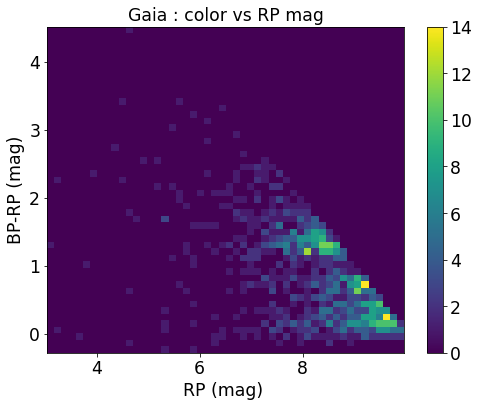

In [17]:
fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
h= ax.hist2d(RP,BP-RP,(50,50))
ax.set_xlabel("RP (mag) ")
ax.set_ylabel("BP-RP (mag)")
plt.colorbar(h[3],ax=ax)
ax.set_title("Gaia : color vs RP mag")

# Select a subset

In [18]:
query_input3 = "select TOP 50 source_id, ra,dec,phot_bp_mean_mag, phot_rp_mean_mag from gaiadr3.gaia_source where dec < -20 and dec> -70 and phot_bp_mean_mag< 10 and phot_rp_mean_mag < 10 and has_xp_continuous = 'True'"
query_input3

"select TOP 50 source_id, ra,dec,phot_bp_mean_mag, phot_rp_mean_mag from gaiadr3.gaia_source where dec < -20 and dec> -70 and phot_bp_mean_mag< 10 and phot_rp_mean_mag < 10 and has_xp_continuous = 'True'"

## Convert the spectrum

In [19]:
converted_spectra, sampling = convert(query_input3)
converted_spectra

INFO: Query finished. [astroquery.utils.tap.core]


,source_id,xp,flux,flux_error
0,5937182165220973312,BP,"[6558.902725563209, 6928.411427355036, 7290.15...","[2005.3310395917854, 2051.950061474963, 2088.9..."
1,5937182165220973312,RP,"[1583.6279402450343, 1677.2123466519172, 1772....","[180.00527748161232, 180.4365577261665, 179.73..."
2,5937183024214130304,BP,"[23285.422881780258, 24437.70251553071, 25541....","[4902.985968584346, 5012.913901016958, 5099.35..."
3,5937183024214130304,RP,"[7053.738519381664, 7484.2633639275355, 7923.4...","[770.8933434427225, 774.4883372028772, 773.555..."
4,5912884401290752512,BP,"[976.7544643043252, 1035.3831013231988, 1093.1...","[107.33675737562525, 109.76091665049216, 111.6..."
...,...,...,...,...
95,5912504623101431040,RP,"[267.3394418637169, 284.75845872128866, 302.65...","[19.7826140036257, 19.84808915053012, 19.78649..."
96,5912847189693373312,BP,"[1591.342026765551, 1677.3296115002004, 1760.6...","[151.68552843546988, 155.52119997819912, 158.6..."
97,5912847189693373312,RP,"[697.0299135225096, 748.4357534595359, 801.766...","[35.55767392496899, 35.707126254382686, 35.640..."
98,5912506444167570432,BP,"[1408.6179655456244, 1491.7379934027558, 1573....","[217.33896521398245, 223.68011911230502, 229.1..."


In [20]:
converted_spectra.columns

Index(['source_id', 'xp', 'flux', 'flux_error'], dtype='object')

## Extract the source id

In [21]:
source_id_list = converted_spectra['source_id']
sources_list = list(np.unique(source_id_list.values)) # The sourceIds can be string or long.
Nsources = len(sources_list)

## Calibrate the spectra

In [22]:
calibrated_spectra, sampling = calibrate(sources_list)
calibrated_spectra

,source_id,flux,flux_error
0,5902496937006001664,"[3.655936909748578e-15, 3.709610436276341e-15,...","[1.0824796795232088e-15, 8.285797766771014e-16..."
1,5912258023256814592,"[1.6548100997455377e-15, 1.7030210605037173e-1...","[2.484224386548511e-16, 1.8325383679911969e-16..."
2,5912259157128424704,"[4.5873490674874437e-14, 4.3647560981710575e-1...","[2.756083410959835e-15, 2.269252266084163e-15,..."
3,5912269842996096128,"[6.358462876974658e-15, 5.624102809337495e-15,...","[5.108564344556214e-16, 3.783135393140179e-16,..."
4,5912271767152252288,"[2.950822422349361e-15, 3.1089833329606025e-15...","[2.2859984212303043e-16, 1.7119636388100447e-1..."
5,5912271801511976192,"[2.182473739611887e-15, 1.9260500786351608e-15...","[1.7592413015742405e-16, 1.2960387226811088e-1..."
6,5912288088028530816,"[2.3474451262956035e-15, 2.3794412130550386e-1...","[4.4159030246068927e-16, 3.259843772154724e-16..."
7,5912309013109563776,"[3.972981210723576e-15, 3.8956242469546246e-15...","[2.3706471072724465e-16, 1.836616706409468e-16..."
8,5912327979685616384,"[6.0683672282698404e-15, 5.811262149191865e-15...","[2.9978846881872474e-16, 2.274999625392998e-16..."
9,5912332446451884416,"[2.6313849973551072e-15, 2.6573782463639485e-1...","[4.001318574948711e-16, 2.9475924744797563e-16..."


## sampling

In [23]:
sampling = np.geomspace(330,1049.9999999999, 361)

In [24]:
calibrated_spectra_geom, sampling = calibrate(sources_list,sampling=sampling,truncation=True)
calibrated_spectra_geom

,source_id,flux,flux_error
0,5902496937006001664,"[1.82759381937339e-14, 1.0771068008239358e-14,...","[4.9762453159711355e-15, 2.161458387093347e-15..."
1,5912258023256814592,"[6.858068731733775e-15, 4.479326805737475e-15,...","[9.594834083103879e-16, 4.827387158484781e-16,..."
2,5912259157128424704,"[6.492082638900269e-14, 5.5177301569778415e-14...","[1.963372585366363e-14, 1.3057692710201102e-14..."
3,5912269842996096128,"[1.6904369522446123e-14, 1.1827888724170536e-1...","[2.4967011126448427e-15, 1.2396591994395118e-1..."
4,5912271767152252288,"[9.525737678011711e-15, 6.659590642796156e-15,...","[1.023776111712438e-15, 5.181885850270142e-16,..."
5,5912271801511976192,"[9.436001884546858e-15, 6.013696917240704e-15,...","[1.4820168421905255e-15, 7.890345772487697e-16..."
6,5912288088028530816,"[1.3648779880158177e-14, 6.965975957747799e-15...","[2.9474998461053936e-15, 1.4916091871877447e-1..."
7,5912309013109563776,"[7.99532045234491e-15, 5.937541934380802e-15, ...","[1.4168231747233331e-15, 9.030707169916365e-16..."
8,5912327979685616384,"[1.0729586601089902e-14, 8.979344488969231e-15...","[1.7544340329130058e-15, 1.0968554325882495e-1..."
9,5912332446451884416,"[8.737072333553092e-15, 5.593703837051842e-15,...","[1.4366552494833683e-15, 7.061535001653618e-16..."


## Plot spectra

In [25]:
my_calib_lines = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,])

In [26]:
len(my_calib_lines.lines)

5

In [27]:
sampling.min()

330.0

In [28]:
def plot_lines(lines,ax,wlmin,wlmax):
    """
    Plot line in a simular way of Spectractor
    """
    xlim=[wlmin,wlmax]
    fontsize=14
    N=len(lines.lines)
    for idx in range(N):
        line=lines.lines[idx]
        color = "r"
        
        ax.axvline(line.wavelength, lw=2, color=color)
        #xpos = (line.wavelength - xlim[0]) / (xlim[1] - xlim[0]) + line.label_pos[0]
        xpos = (line.wavelength - xlim[0]) / (xlim[1] - xlim[0]) 
        if 0 < xpos < 1:
            ax.annotate(line.label, xy=(xpos, line.label_pos[1]), rotation=90, ha='left', va='bottom',
                            xycoords='axes fraction', color=color, fontsize=fontsize)
          
    return ax


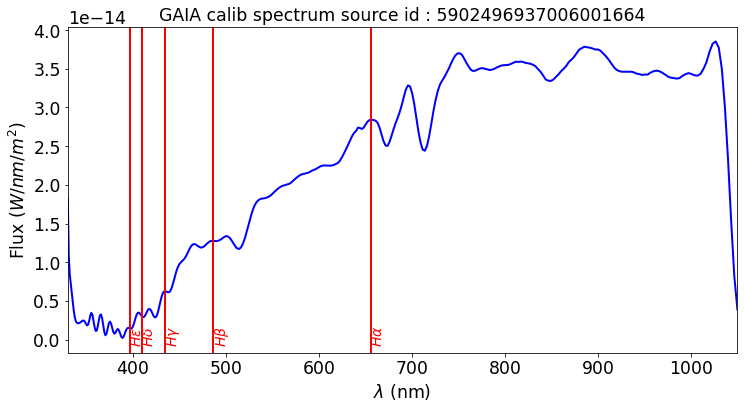

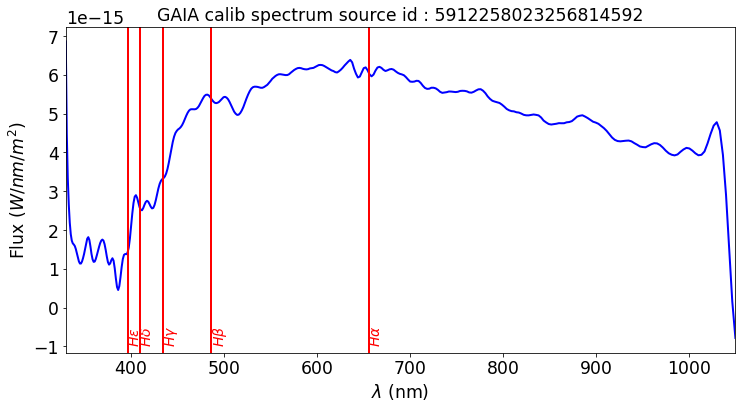

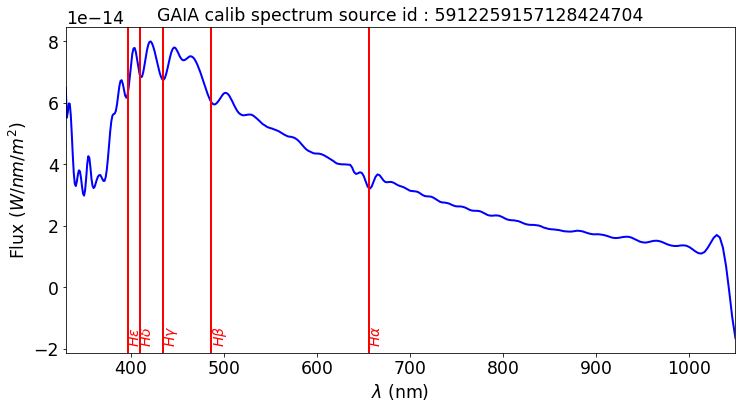

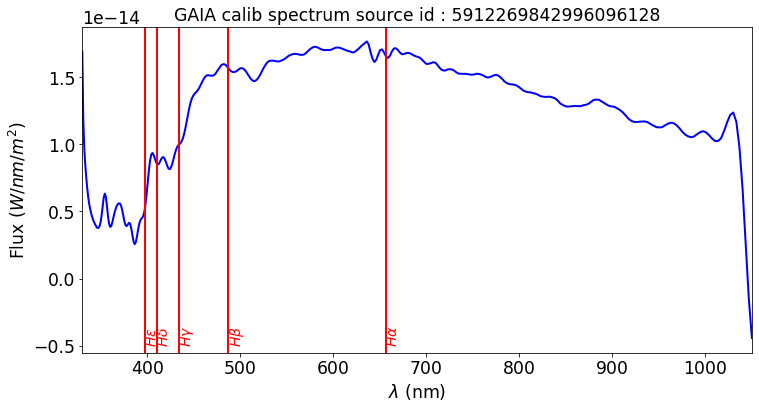

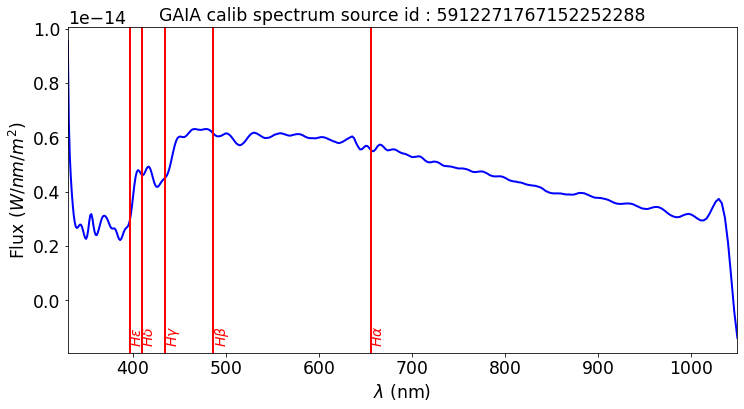

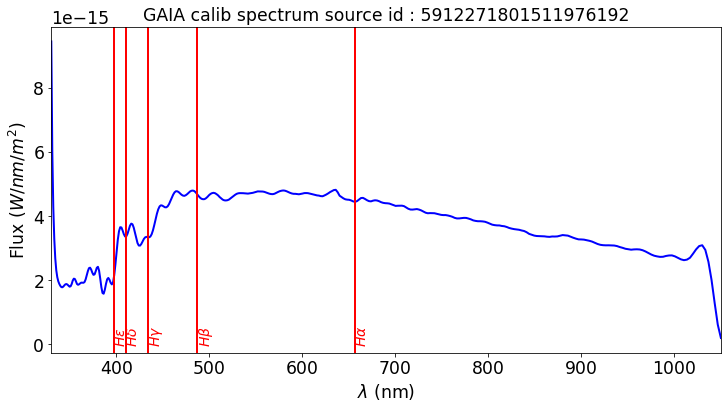

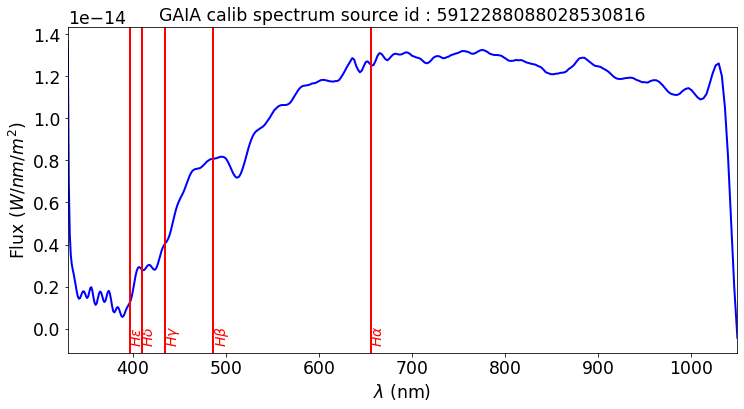

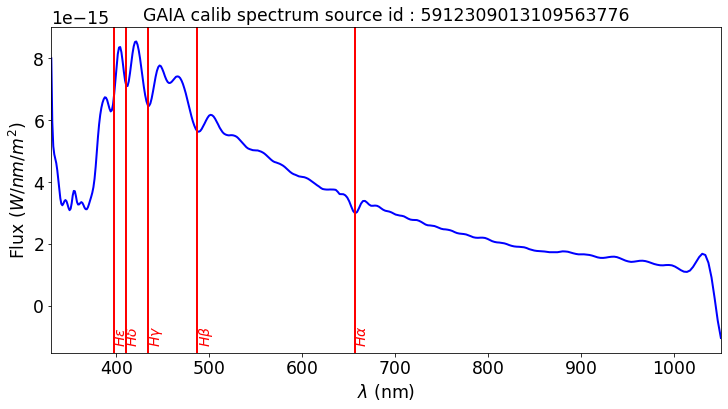

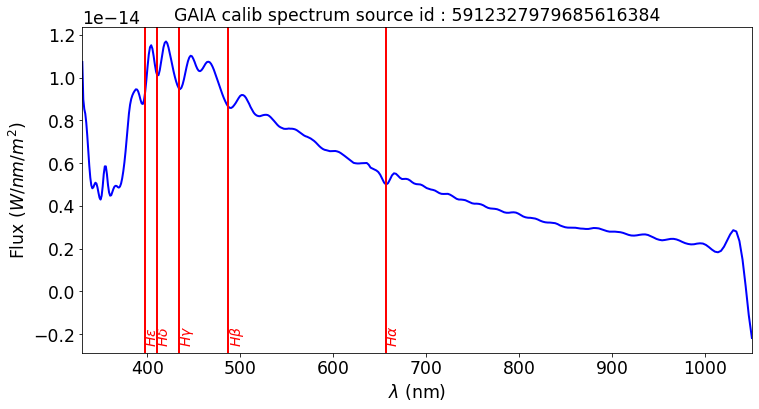

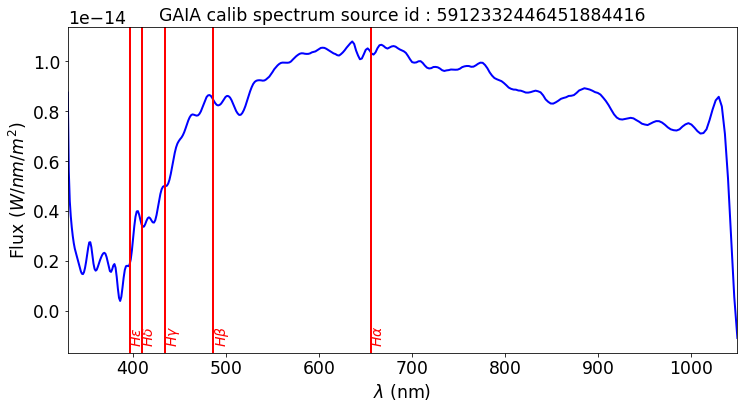

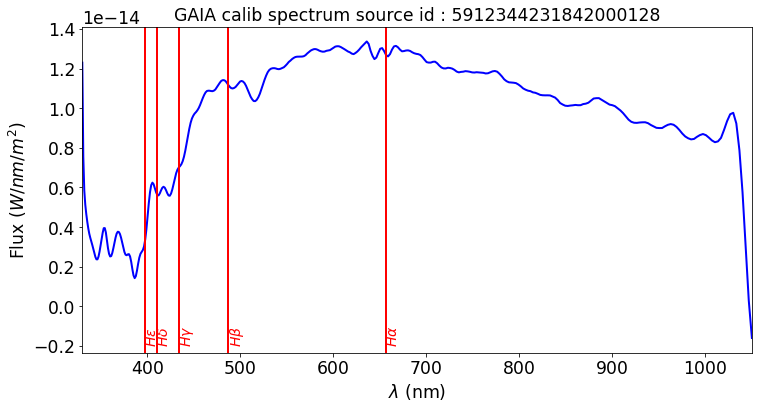

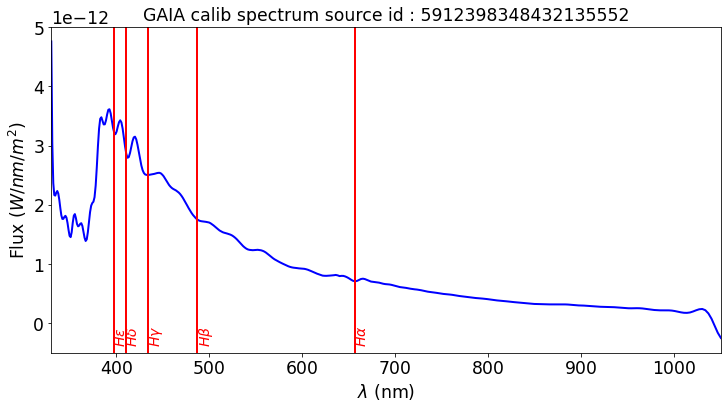

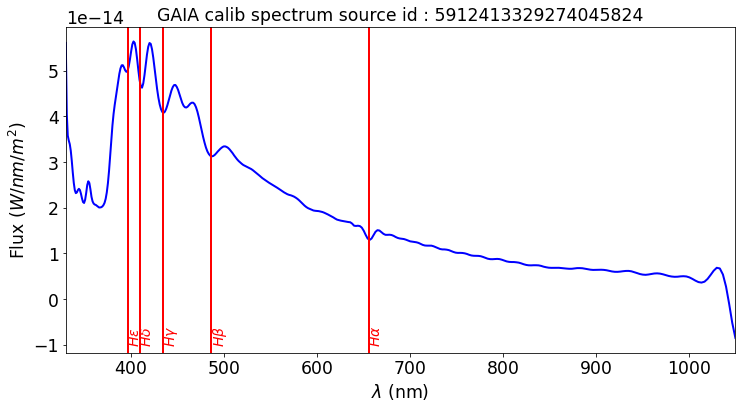

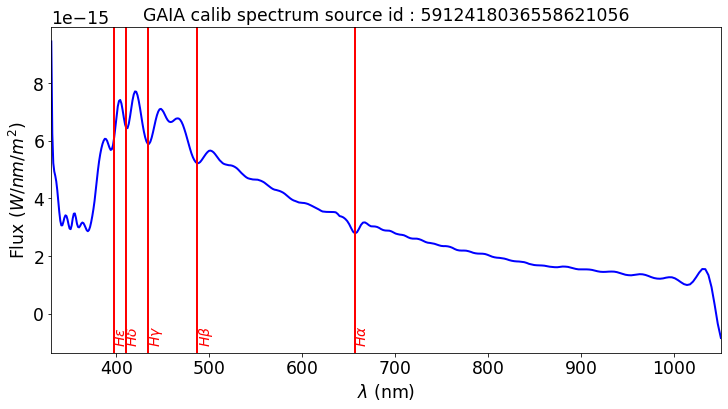

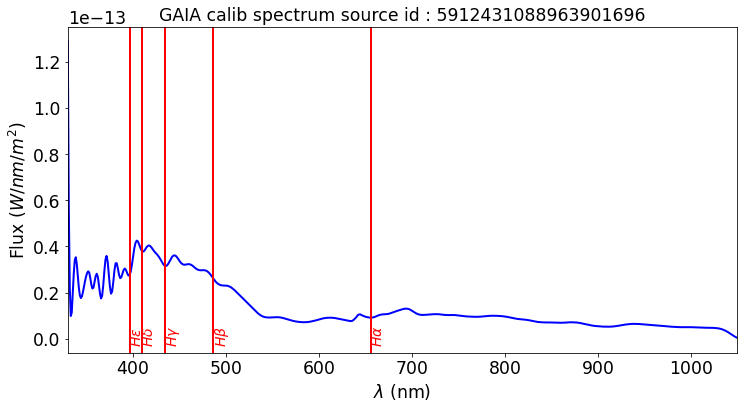

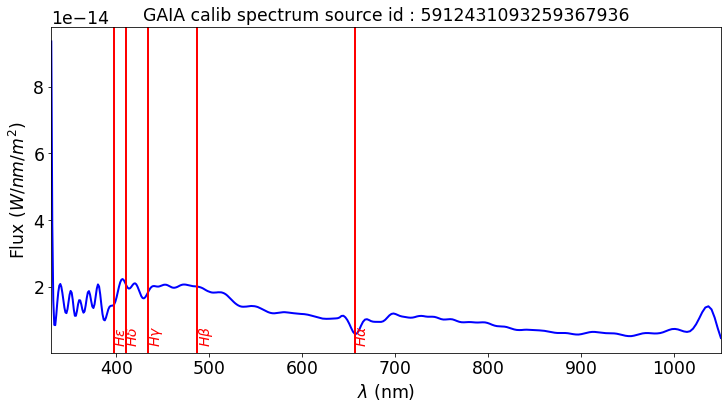

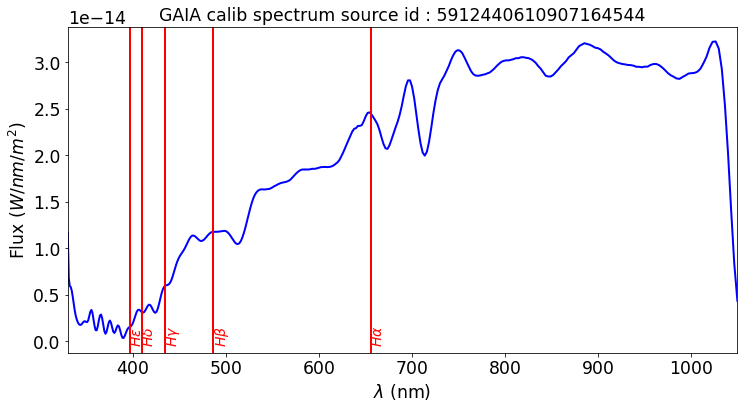

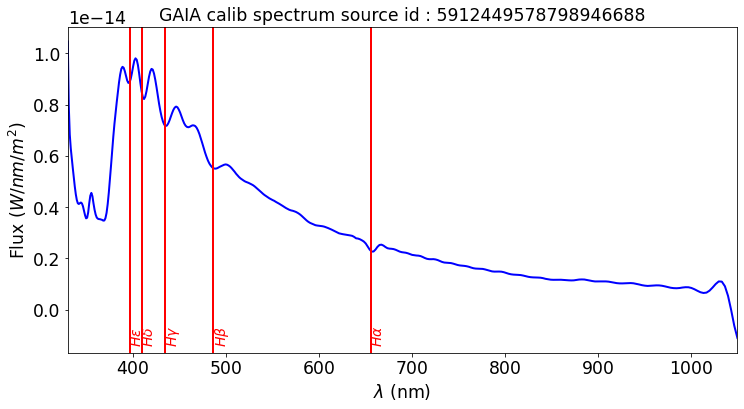

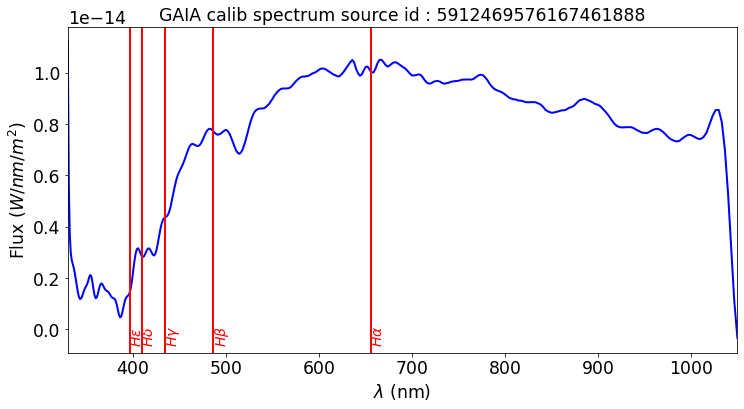

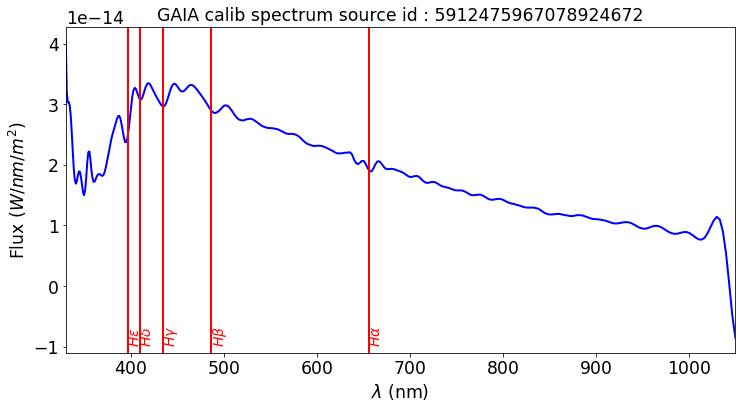

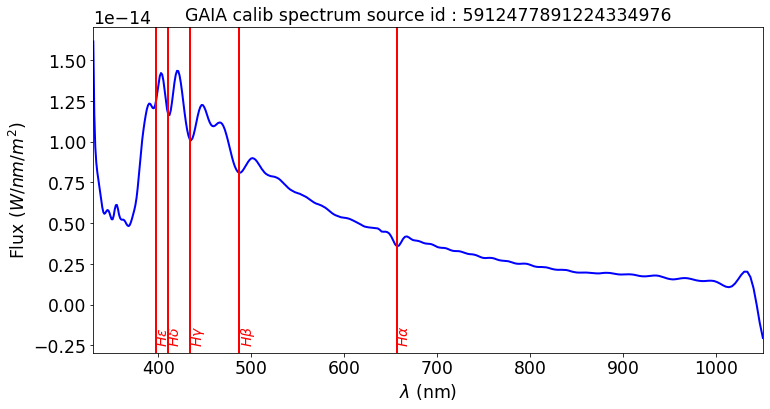

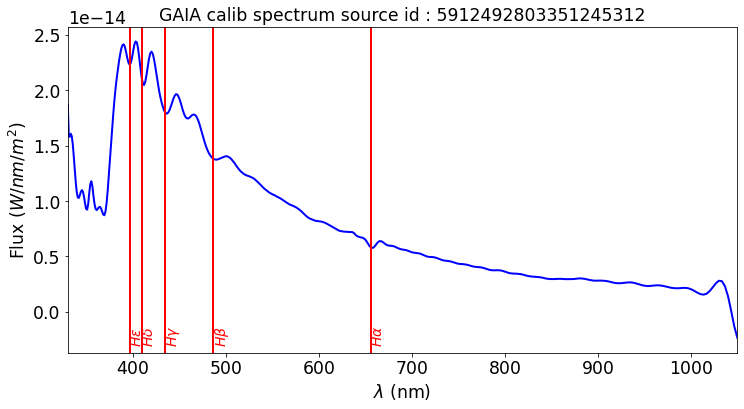

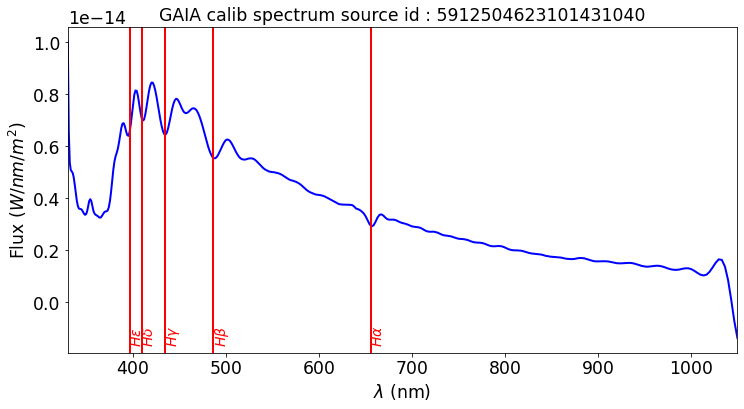

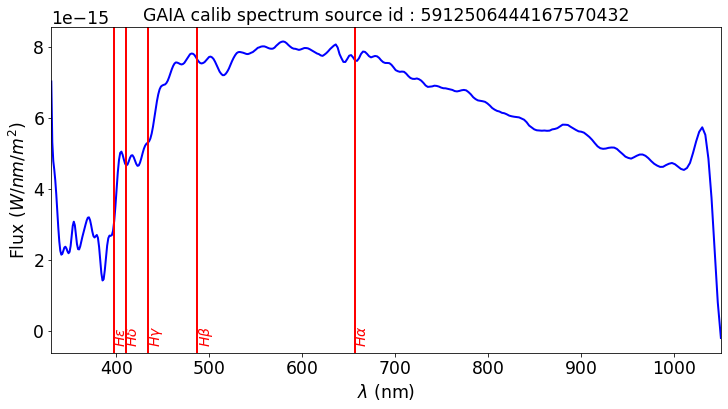

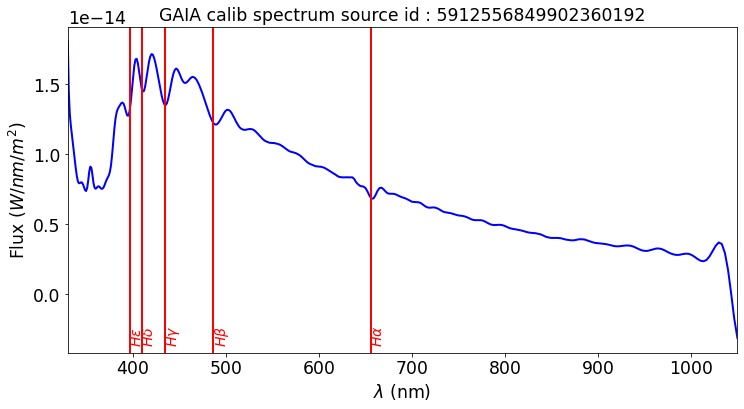

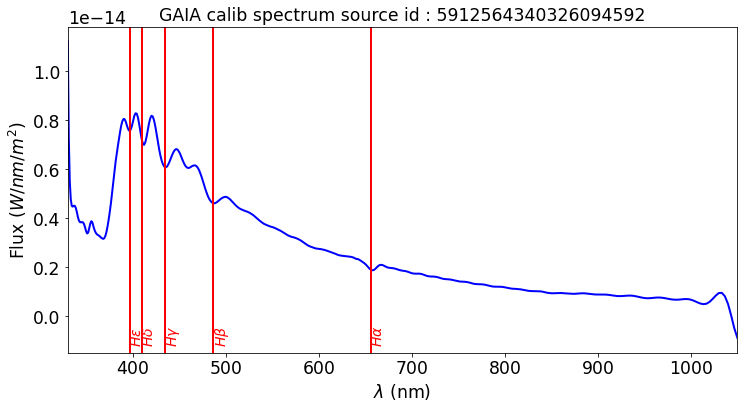

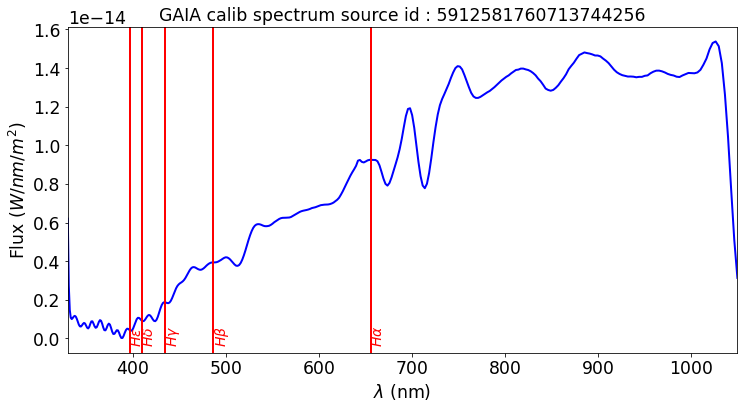

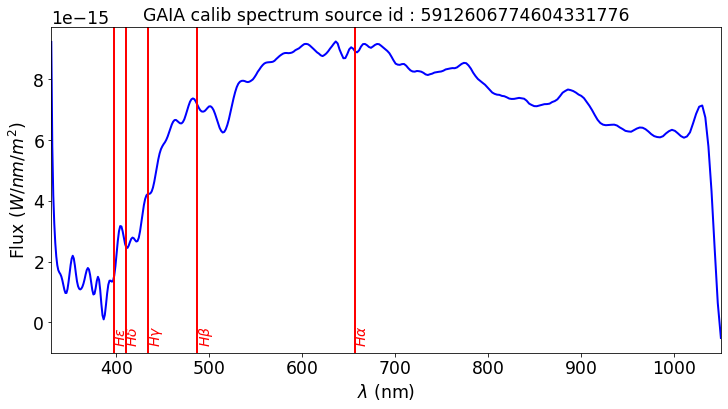

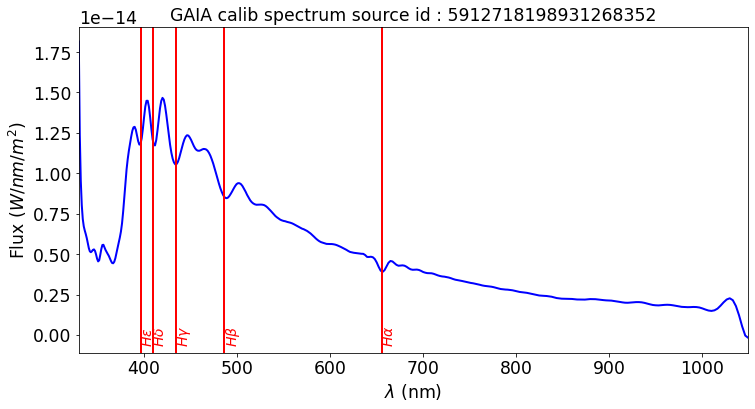

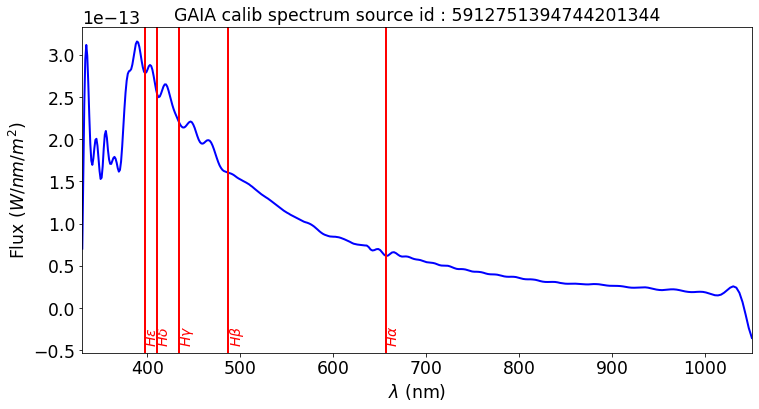

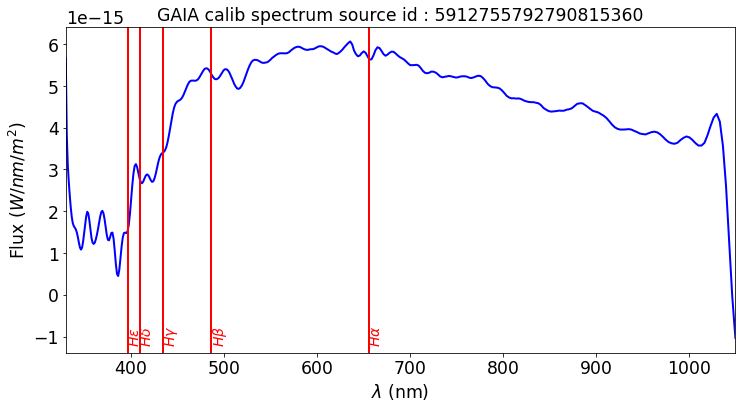

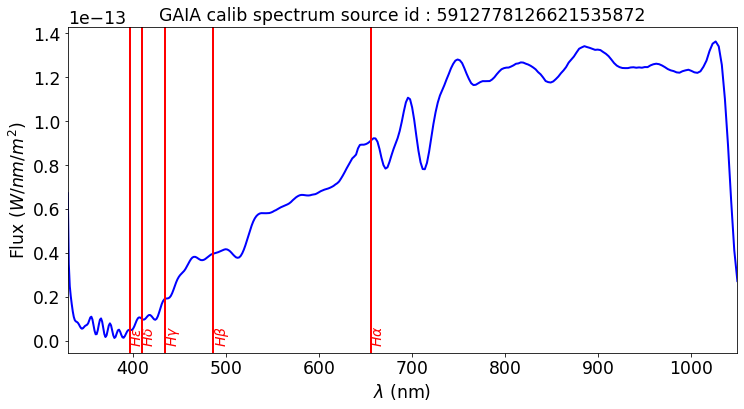

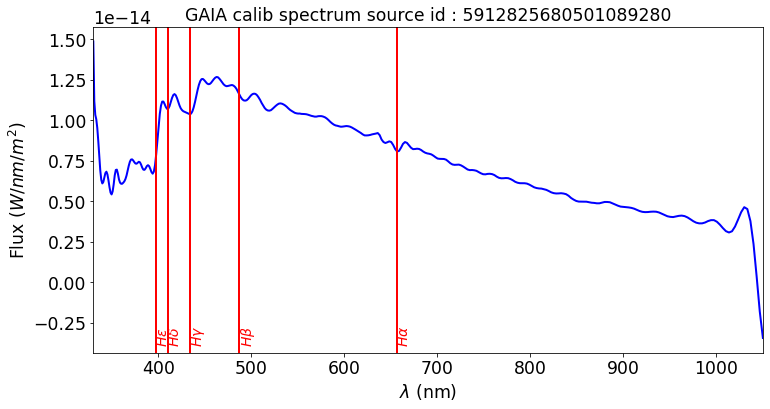

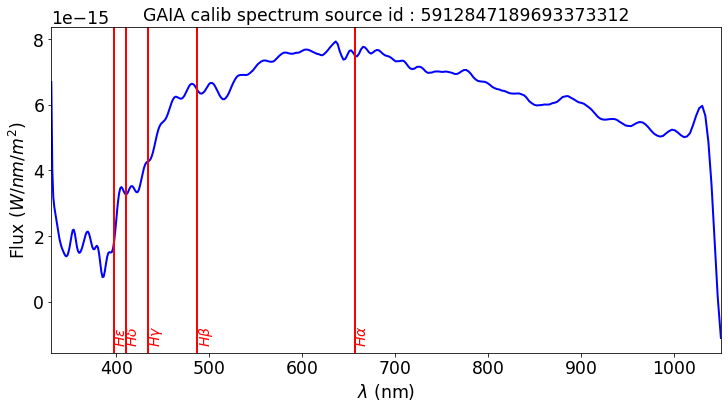

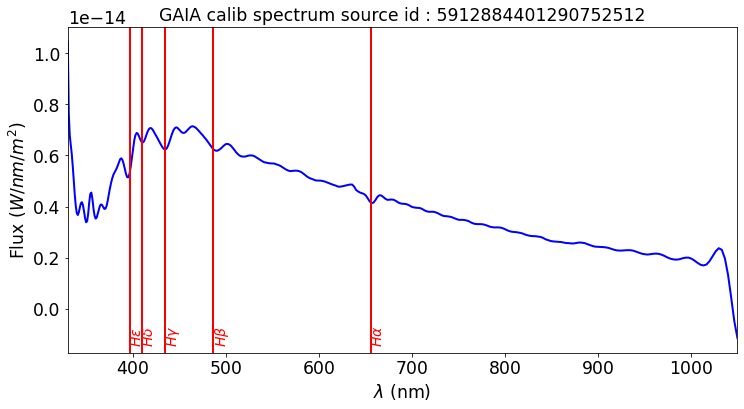

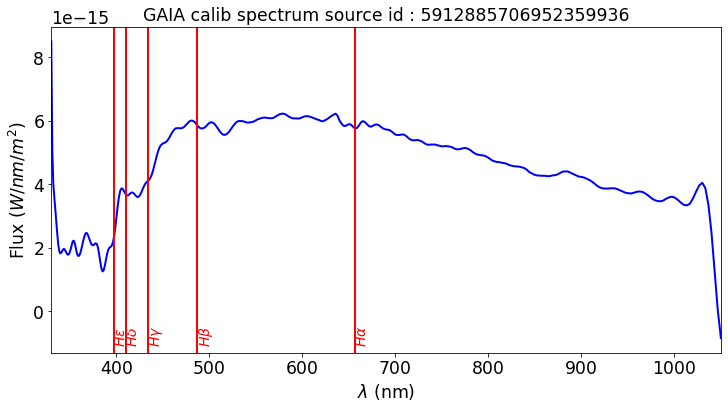

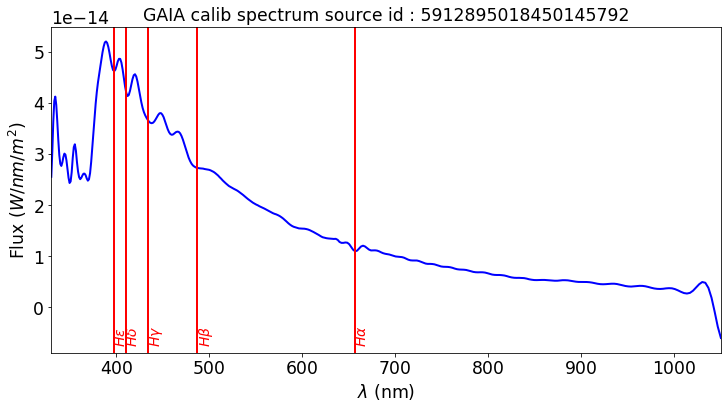

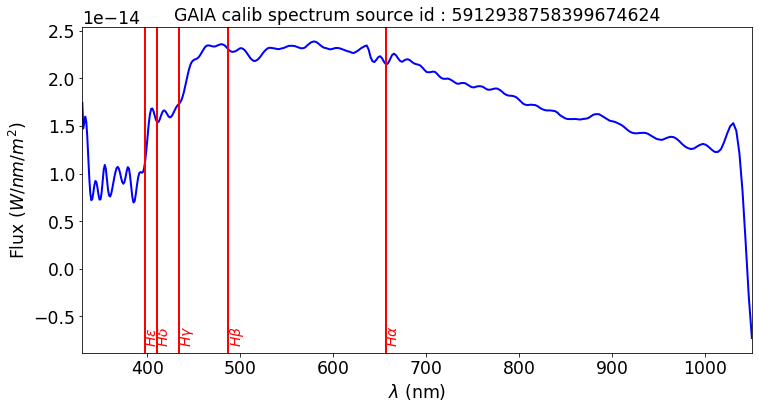

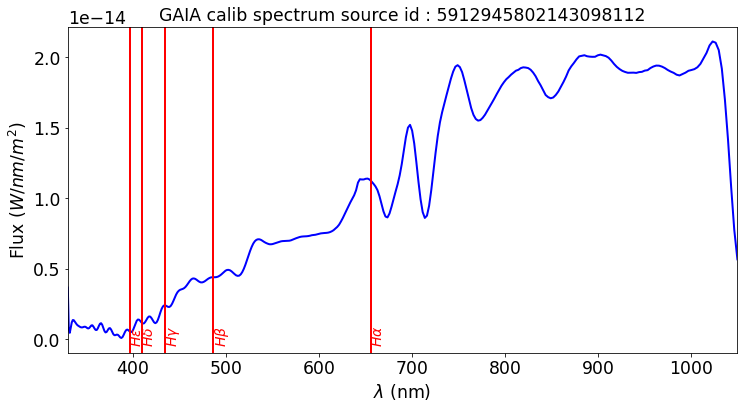

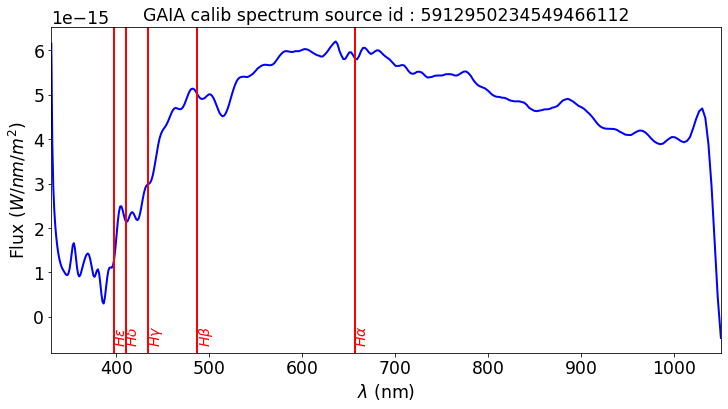

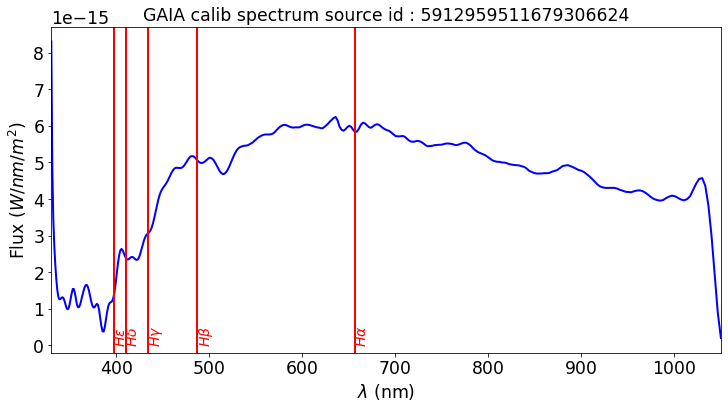

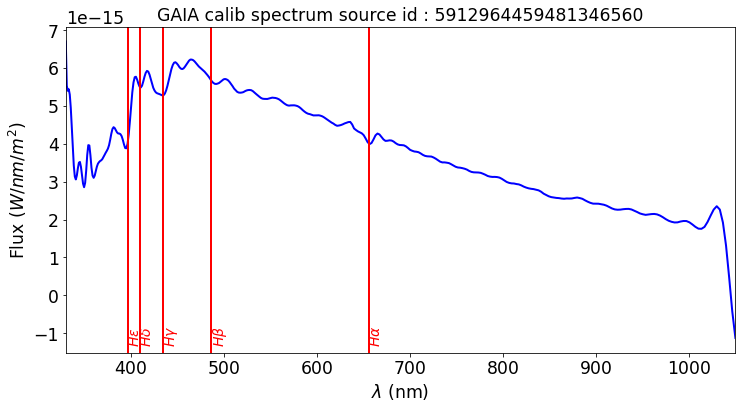

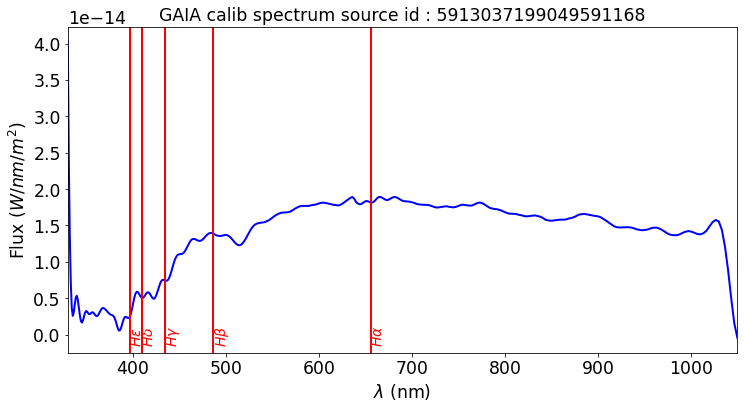

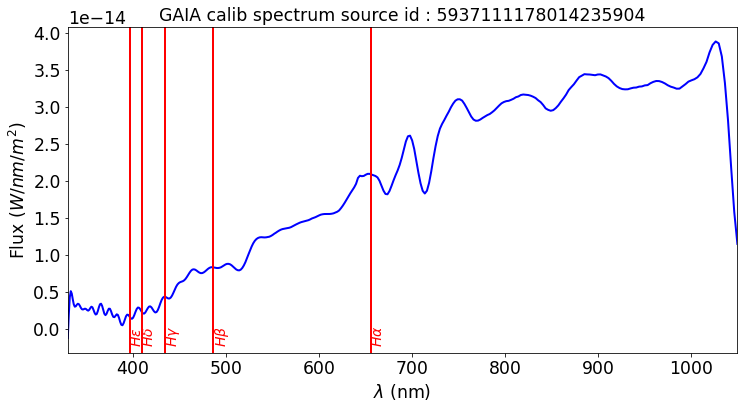

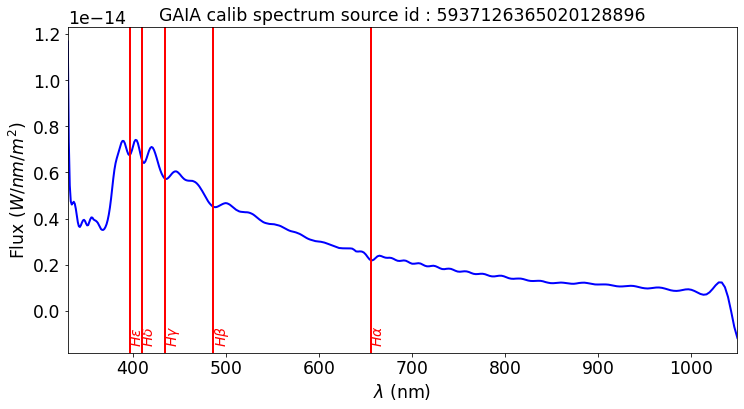

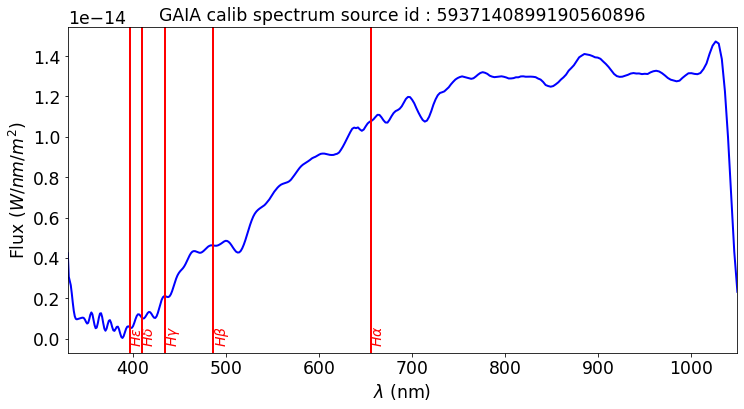

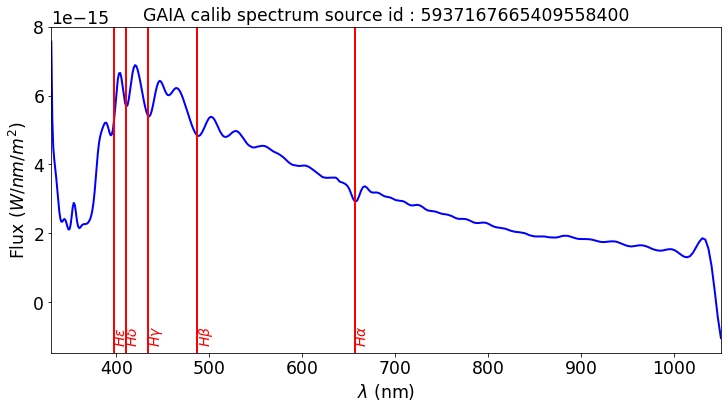

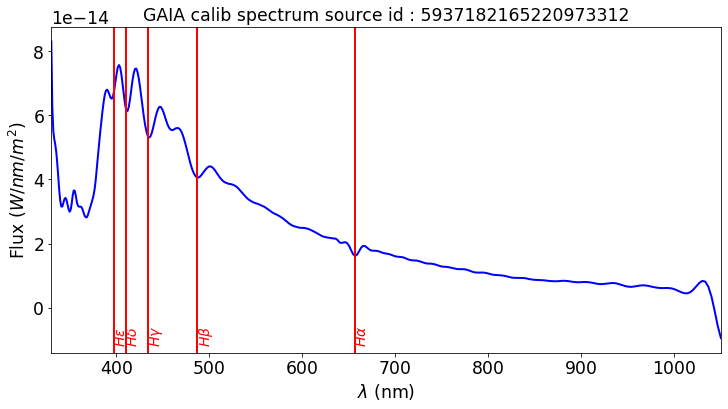

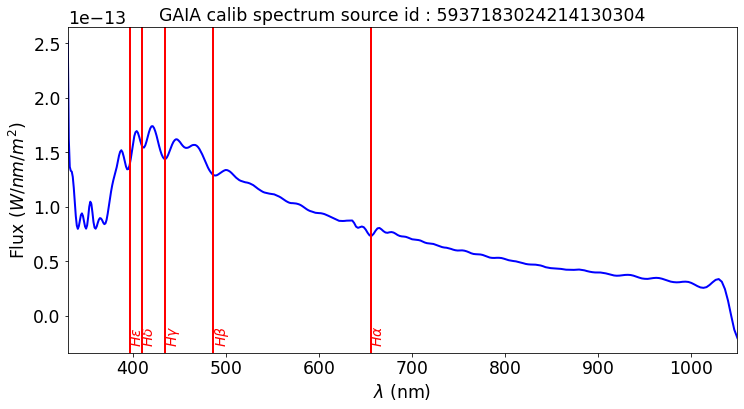

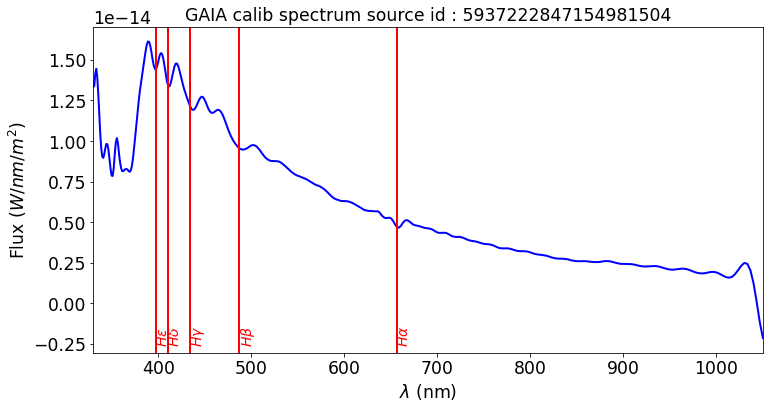

In [29]:
for idx in range(Nsources):
    plt.figure()
    plt.plot(sampling,calibrated_spectra_geom.iloc[idx]["flux"],'b-')
    ax = plt.gca()
    plot_lines(my_calib_lines,ax,sampling.min(),sampling.max())
    plt.xlim(sampling.min(),sampling.max())
    
    #plt.axvline(HALPHA.wavelength, lw=2, color="r")
    the_title="GAIA calib spectrum source id : "+ str(calibrated_spectra_geom.iloc[idx]["source_id"])
    plt.title(the_title)
    plt.xlabel("$\lambda$ (nm)")
    plt.ylabel("Flux ($W/nm/m^2$)")
    plt.show()

# Plotting by gaiaxpy

- to check if my plotting is correct

In [30]:
#for idx in range(Nsources):
#    the_source  = calibrated_spectra_geom.iloc[[idx]] # Select row with index idx
#    plot_spectra(the_source, sampling=sampling, legend=True)